In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

import datagenerators as dg

In this post, I will be using the excellent [`CausalInference`](http://causalinferenceinpython.org/) package to give an overview of how we can use the [potential outcomes](https://en.wikipedia.org/wiki/Rubin_causal_model) framework to try and make causal inferences about situations where we only have observational data. The author has a good series of [blog posts](http://laurence-wong.com/software/) on it's functionality.

Because most datasets you can download are static, throughout this post I will be using be using my own functions to generate data. This has two advantages: we can and will generate datasets with specific properties, and we have the ability to "intervene" in the data generating system directly, giving us the ability to check whether our inferences are correct. These data generators all generate [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) samples from some distribution, returning the results as a pandas dataframe. You can the functions which generate these datasets in the accompanying file `datagenerators.py`.

To begin, let's look at a motivating example.

# Introduction

One day a team lead notices that some members of their team wear cool hats, and that these members of the team tend to be less productive. Being data drive, the Team Lead starts to record whether or not a team member wears a cool hat ($X=1$ for a cool hat, $X=0$ for no cool hat) and whether or not they are productive ($Y=1$ for productive, $Y=0$ for unproductive).

After making observations for a week, they end up with a dataset like the following:

In [2]:
observed_data_0 = dg.generate_dataset_0()

observed_data_0.head()

,x,y
0,1,1
1,1,0
2,0,0
3,1,1
4,1,0


The first question the team lead asks is: are people wearing cool hats more likely to be productive that those who don't? This means estimating the quantity

$P(Y=1|X=1) - (Y=1|X=0)$

which we can do directly from the data:

In [3]:
def estimate_uplift(ds):
    """
    Estiamte the difference in means between two groups.
    This is closer related to the z and t tests 
    
    Parameters
    ----------
    ds: pandas.DataFrame
        a dataframe of samples.
        
    Returns
    -------
    estimated_uplift: dict[Str: float] containing two items:
        "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
        "standard_error" - 90% confidence intervals arround "estimated_effect"
        
        
    """
    base = ds[ds.x == 0]
    variant = ds[ds.x == 1]
    
    delta = variant.y.mean() - base.y.mean()
    delta_err = 1.96 * np.sqrt(
        variant.y.var() / variant.shape[0] + 
        base.y.var() / base.shape[0])
    
    return {"estimated_effect": delta, "standard_error": delta_err}

estimate_uplift(observed_data_0)

{'estimated_effect': -0.1124449779911964, 'standard_error': 0.0872639534672425}

It looks like people with cool hats are less productive. 

To be sure, we can even run a statistical test:

A chi-square test tests a null hypothesis about the relationship between two variables. For example, you could test the hypothesis that men and women are equally likely to vote "Democratic," "Republican," "Other" or "not at all." A chi-square test requires categorical variables, usually only two, but each may have any number of levels, whereas A t-test requires two variables; one must be categorical and have exactly two levels, and the other must be quantitative and be estimable by a mean.   

In [4]:
from scipy.stats import chi2_contingency

contingency_table = (
    observed_data_0
    .assign(placeholder=1)
    .pivot_table(index="x", columns="y", values="placeholder", aggfunc="sum")
    .values
)

_, p, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")

# p-value
p

0.015210293032033802

That's one small p-value. [Staticians would be proud](https://www.nature.com/articles/s41562-017-0189-z).

We can use this information to make statements about what we might think about someone's probability if we see them wearing a cool hat. As long as we believe that they are "drawn from the same distribution" as our previous observations, we expect the same correlations to exist. 

The problem comes if we try to use this information as an argument about whether or not the team lead should **force** people to wear cool hats. If the team lead does this they fundamentally change the system we are sampling from, potentially altering or even reversing any correlations we observed before.

The cleanest way to actually measure the effect of some change in a system is by running a [randomized control trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial). Specifically, we want to randomize who gets cool hats and who doesn't, and look at the different values of $y$ we receive. This removes the effect of any [confounding variables](https://en.wikipedia.org/wiki/Confounding) which might be influencing the metric we care about.

Because we generated our dataset from a known process (in this case a function I wrote), we can intervene in it directly and measure the effect of an A/B test:

In [5]:
## This is simply running the experiment, generating the data and
## identifying the results
def run_ab_test(datagenerator, n_samples=10000, filter_=None):
    """
    Generates n_samples from datagenerator with the value of X randomized
    so that 50% of the samples recieve treatment X=1 and 50% receive X=0,
    and feeds the results into `estimate_uplift` to get an unbiased 
    estimate of the average treatment effect.
    
    Returns
    -------
    effect: dict
    """
    n_samples_a = int(n_samples / 2)
    n_samples_b = n_samples - n_samples_a
    set_X = np.concatenate([np.ones(n_samples_a), np.zeros(n_samples_b)]).astype(np.int64)
    ds = datagenerator(n_samples=n_samples, set_X=set_X)
    if filter_ != None:
        ds = ds[filter_(ds)].copy()
    return estimate_uplift(ds)

run_ab_test(dg.generate_dataset_0)

{'estimated_effect': 0.18280000000000002,
 'standard_error': 0.01927109381522959}

Suddenly, it looks like the direction of the effect of wearing cool hats has reversed. 

What's going on?

Note: In the above example, and in all following examples, I'm assuming that our samples are [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), and obey the [Stable unit treatment value assumption (SUTVA)](https://en.wikipedia.org/wiki/Rubin_causal_model#Stable_unit_treatment_value_assumption_%28SUTVA%29). Basically this means that when one person chooses, or is forced to wear a really cool hat they have no influence on the choice or effect of another person wearing a really cool hat. By construction, the synthetic datagenerators I use all have this property. In reality it is yet another thing you have to assume to be true.

# Definitions of Causality 

The previous example demonstrates the old statistics saying: 

[**Correlation Does Not Imply Causation**](https://xkcd.com/552/).

["Causality"](https://plato.stanford.edu/entries/causation-metaphysics/) is a vague, philosophical sounding word. In the current context, I am using it to mean "What is the effect on $Y$ of changing $X$?"

To be precise, $X$ and $Y$ are [random variables](http://mathworld.wolfram.com/RandomVariable.html) and the "effect" we want to know is how the distribution of $Y$ will change when we for $X$ to take a certain value. This act of forcing a variable to take a certain value is called an "Intervention".

In the previous example, when we make no intervention on the system, we have an observational distribution of $Y$, conditioned on the fact we observe $X$:

$P(Y|X)$

When we force people to wear cool hats, we are making an intervention. The distribution of $Y$ is then given by the _interventional_ distribution 

$P(Y|\hbox{do}(X))$

In general these two are not the same.

#### The question these notes will try and answer is how we can reason about the interventional distribution, when we only have access to observational data. 
This is a useful question because there are lots of situations where running an A/B test to directly measure the effects of an intervention is impractical, unfeasable or unethical. In these situations we still want to be able to say something about what the effect of an intervention is - to do this we need to make some assumptions about the data generating process we are investigating.

# Potential Outcomes 

One way to approach this problem is to introduce two new random variables to our system: $Y_{0}$ and $Y_{1}$, known as the [Potential Outcomes](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf). We imagine that these variables exist, and can be treated as any other random variable - the only difference is that they are never directly observed. $Y$ is defined in terms of 

 - $Y = Y_{1}$ when $X=1$
 - $Y = Y_{0}$ when $X=0$
 
This shifts the problem from one about how distributions change under the intervention, to one about data drawn i.i.d. from some underlying distribution with [missing values](https://en.wikipedia.org/wiki/Missing_data). Under certain assumptions about why values are missing, there is well developed theory about how to estimate the missing values.

# Goals

Often we do not care about the full interventional distribution, $P(Y|\hbox{do}(X))$, and it is enough to have an estimate of the difference in means between the two groups. This is a quantity known as the [Average Treatment Effect](https://en.wikipedia.org/wiki/Average_treatment_effect):

$\Delta = E[Y_{1} - Y_{0}]$

When we run and A/B test and compare the means of each group, this is directly the quantity we are measuring 

If we just try and estimate this quantity from the observational distribution, we get:

$\Delta_{bad} = E[Y|X=1] - E[Y|X=0] \\
= E[Y_{1}|X=1] - E[Y_{0}|X=0] \\
\neq \Delta$

This is not generally equal to the true ATE because:

$E[Y_{i}|X=i] \neq E[Y_{i}]$

Two related quantities are 

 - $ATT = E[Y_{1} - Y_{0}|X=1]$, the "Average Treatment effect of the Treated"
 - $ATC = E[Y_{1} - Y_{0}|X=0]$, the "Average Treatment effect of the Control"

One way to interpret ATC is as a measure of the effect of treating only samples which wouldn't naturally be treated, and vice versa for ATT. Depending on your use case, they may be more natural measures of what you care about. The following techniques will allow us to estimate them all. 

$\def\ci{\perp\!\!\!\perp}$
# Making Assumptions

When we A/B test, we randomize the assignment of $X$. This has the effect of allowing us to choose which variable of $Y_{1}$ or $Y_{0}$ is revealed to us. This makes the outcome independent of the value of $X$. We write this as

$Y_{1}, Y_{0} \ci X$

Which means that the distribution of $X, Y_{0}, Y_{1}$ factorizes as

$P(X, Y_{0}, Y_{1}) = P(X)P(Y_{0}, Y_{1})$

If this independence holds then

$E[Y_{1}|X=1] = E[Y_{1}]$

If we want to estimate the ATE using observational data, we need to use other information we have about the samples - specifically we need to **assume** that we have enough additional information to completely explain the choice of treatment each subject.

If we call the additional information the random variable $Z$, we can write this assumption as

$Y_{1}, Y_{0} \ci X \, | \, Z$

or

$P(X, Y_{0}, Y_{1}| Z) = P(X|Z)P(Y_{0}, Y_{1}|Z)$

This means that the observed treatment a sample receives, $X$, is completely explained by $Z$. This is sometimes called the ["ignorability" assumption](https://en.wikipedia.org/wiki/Ignorability).

In our motivating example about cool hats this would mean that there is some other factor - let's call it "skill" - which impacts both the productivity of the person and whether or not they wear a cool hat. In our example above, skilled people are more likely to be productive and also less likely to were cool hats. These facts together _could_ explain why the effect of cool hats seemed to reverse when ran an A/B test. 

If we split our data on whether or not the person is skilled, we find that for each subgroup there is a positive relationship between wearing cool hats and productivity:

In [6]:
observed_data_0_with_confounders = dg.generate_dataset_0(show_z=True)

print(estimate_uplift(observed_data_0_with_confounders.loc[lambda df: df.z == 0]))
print(estimate_uplift(observed_data_0_with_confounders.loc[lambda df: df.z == 1]))

{'estimated_effect': 0.27482993197278915, 'standard_error': 0.188445544210971}
{'estimated_effect': 0.17722371967654982, 'standard_error': 0.1682049896229768}


Unfortuntly, because we never observe $Y_{0}$ and $Y_{1}$ for the same sample, we cannot test the assumption that 

$Y_{1}, Y_{0} \ci X \, | \, Z$

It is something we have to use our knownledge of the system we are investigating to evaluate.

The quality of any prediction you make depends on exactly how well this assumption holds. [Simpson's Paradox](http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/) is an extreme example of the fact that if $Z$ does not give contain all confounding variables, then any inference we make could be wrong. [Facebook have a good paper comparing different causal inference approaches with direct A/B test that show how effects can be overestimated when conditional independence doesn't hold](https://www.kellogg.northwestern.edu/faculty/gordon_b/files/kellogg_fb_whitepaper.pdf).

Once we have made this assumption there are a number of techniques for approaching this. I will outline a few of simpler approaches in the rest of the post, but keep in mind that this is a area of ongoing research.

In human speak you can investigate the counterfactual with an additional variable, but you should trust this apprach less than interventionist studies.

# Modeling the Counterfactual

From the above, it should be clear that if know $Y_{0}$ and $Y_{1}$, we can estimate the ATE. So why not just try and model them directly? Specifically we can build estimators: 
 
 - $\hat{Y}_{0}(Z) = E[Y|Z, X=0]$
 - $\hat{Y}_{1}(Z) = E[Y|Z, X=1]$. 
 
If we can model these two quantities, we can estimate the ATE as:

$\Delta = \frac{1}{N}\sum_{i}(\hat{Y}_{1}(z_{i}) - \hat{Y}_{0}(z_{i}))$

The success of this approach depends on how well we can model the potential outcomes. To see it in action, let's use the following data generating process:

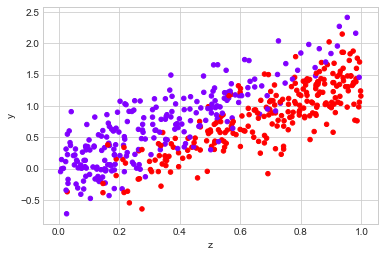

In [8]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False);

Before jumping into modelling the counterfactual, let's look at the data. If we look at how $Y$ is distributed, there appears to be a small difference between the two groups:

In [15]:
## Not really treated, just different

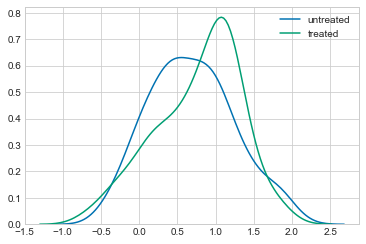

In [14]:
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 0].y, label="untreated")
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 1].y, label="treated")

We can confirm this by looking at the difference in means between the two groups

In [16]:
print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))

Observed ATE: 0.088 (0.098)


However, if we look at the distribution of the covariance, $Z$, it is clear that there is a difference between the groups. 

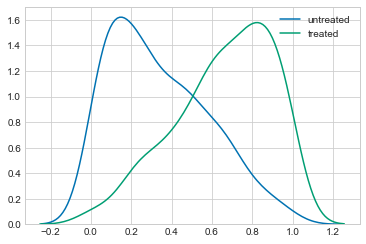

In [17]:
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 0].z, label="untreated")
sns.kdeplot(observed_data_1.loc[lambda df: df.x == 1].z, label="treated")

If we believe that $Z$ has some infulance on the metric $Y$, this should concern us. We need some way to disentangle the effect of $X$ on $Y$ and the effect of $Z$ on $Y$.

We can check the actually ATE using our simulated A/B test and confirm that it is difference of the observed value:

In [18]:
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

Real ATE:  -0.488 (0.026)


But what happens if we cannot run this A/B test? We need to resort to modelling the system.

The simplest type of model we can use is a linear model. Specifically we could assume 

$Y_{0} = \alpha + \beta Z + \epsilon$

$Y_{1} = Y_{0} + \gamma$

If this is accurate, fitting the model

$Y = \alpha + \beta Z + \gamma X$

to the data using linear regression will give us an estimate of the ATE.

The `causalinference` package gives us a simple interface to do this:

In [37]:
observed_data_1.x.values + observed_data_1.z.values

array([[0.45977266, 1.45977266, 0.45977266, ..., 1.45977266, 0.45977266,
        1.45977266],
       [0.46528151, 1.46528151, 0.46528151, ..., 1.46528151, 0.46528151,
        1.46528151],
       [0.09362287, 1.09362287, 0.09362287, ..., 1.09362287, 0.09362287,
        1.09362287],
       ...,
       [0.81179512, 1.81179512, 0.81179512, ..., 1.81179512, 0.81179512,
        1.81179512],
       [0.36630601, 1.36630601, 0.36630601, ..., 1.36630601, 0.36630601,
        1.36630601],
       [0.69544762, 1.69544762, 0.69544762, ..., 1.69544762, 0.69544762,
        1.69544762]])

In [19]:
df = pd.DataFrame()
df["D"] = observed_data_1.x.values 

In [20]:
df["X"] = observed_data_1.z.values 

In [23]:
df["Y"] = list(observed_data_1.y.values) 

In [26]:
import statsmodels.api as sm # i
df_full = sm.add_constant(df[["D","X","Y"]]); df_full

,const,D,X,Y
0,1.0,0,0.167380,0.368381
1,1.0,1,0.650004,0.937025
2,1.0,1,0.724620,0.770558
3,1.0,1,0.986436,1.761892
4,1.0,1,0.328730,-0.048466
5,1.0,0,0.315979,1.113640
6,1.0,0,0.647366,1.302902
7,1.0,0,0.070309,0.012605
8,1.0,0,0.118775,0.821925
9,1.0,0,0.532817,0.984217


In [30]:
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest
## The automated discovery might not work, but you know it exists
variable_types = {'const' : 'u', 'D' : 'u', 'X' : 'c', 'Y': 'u'}

ic_algorithm = IC(RobustRegressionTest)
graph = ic_algorithm.search(df_full, variable_types)

In [31]:
graph.edges(data=True)

[('const', 'X', {'arrows': [], 'marked': False}),
 ('D', 'X', {'arrows': [], 'marked': False}),
 ('D', 'Y', {'arrows': [], 'marked': False}),
 ('X', 'Y', {'arrows': [], 'marked': False})]

In [32]:
import pandas as pd
import numpy as np
from causality.estimation.parametric import PropensityScoreMatching


In [38]:
import scipy.io as sio
test = sio.loadmat('data/cina0_train.mat')

In [36]:
test

{'X': array([[1, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Jan 10 13:49:59 2008',
 '__version__': '1.0'}

In [45]:
constants.shape

(501, 500)

In [29]:
import statsmodels.api as sm # import statsmodels 

Y=observed_data_1.y.values
D = observed_data_1.x.values
X = observed_data_1.z.values
# Note the difference in argument order
model = sm.OLS(Y, df_full).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.884e+31
Date:                Sun, 01 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:51:21   Log-Likelihood:                 16689.
No. Observations:                 500   AIC:                        -3.337e+04
Df Residuals:                     496   BIC:                        -3.335e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.506e-16   7.05e-17    -13.479      0.000   -1.09e-15   -8.12e-16
D           1.839e-16   1.03e-16      1.793      0.074   -1.76e-17    3.85e-16
X           5.412e-16   2.69e-16      2.011      0.045    1.26e-17    1.07e-15
Y              1.0000   1.12e-16   8.93e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                       95.891   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.491
Skew:                           0.008   Prob(JB):                     3.55e-05
Kurtosis:                       2.008   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
## D is the determinant, the hat wearers, X is the Z (control)
## There is no difference between runnig a normal linear regression and
## runnning this causal model. 
from causalinference import CausalModel

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_via_ols(adj=1)

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.533      0.030    -17.739      0.000     -0.592     -0.474



/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


`causalinference` returns an estimate of the ATE, along with some statistical properties of the estimate. It is important to realise that the confidence intervals reported for the estimates are the confidence intervals _if we assume the model accurately describes the counterfactual_, not confidence intervals about how well the the model describes the counterfactual.

In this case the package has done well in identifying the correct ATE - which is good, but the data generating process was specifically designed to meet the assumptions. Let's look at a few cases where it might fail.

The first is when the effect is not simply additive:

Observed ATE: 0.684 (0.102)
Real ATE:  0.539 (0.030)


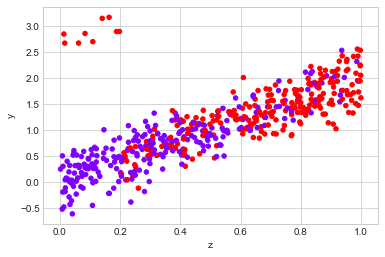

In [52]:
observed_data_2 = dg.generate_dataset_2()

observed_data_2.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_2)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_2)))

In [53]:
# Linear Regression helps to decribe the countefactual. 
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_ols(adj=1)

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.207      0.075      2.765      0.006      0.060      0.353



/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


Usually this can be overcome by using more powerful estimators . A simple, non-parametric approach, is the technique of [matching](https://en.wikipedia.org/wiki/Matching_%28statistics%29). The idea is to find for each sample which received the treatment, a similar samples which did not receive the treatment, and to directly compare these values. Exactly what you mean by "similar" will depend on your specific usecase., 

The package `causalinference` implements matching by selecting for each unit, with replacement, the most similar unit from the other treatment group and using the difference between these two units to calculate the ATE. By default, the choice of match is chosen to be the nearest neighbour in covariate space $Z$, with the distances weighted by inverse variance of each dimension.

There are options to change the number of units compared and the weighting of each dimension in the match. For more details, see the [documentation](http://laurence-wong.com/software/matching).

We can compute the matching estimate with the following code

In [54]:
## Simply a better way to describe controls 
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.460      0.130      3.537      0.000      0.205      0.715
           ATC      0.866      0.128      6.772      0.000      0.615      1.117
           ATT      0.041      0.188      0.216      0.829     -0.328      0.410



The confidence intervals around our estimate now contain the true ATE.

# Covariate Imbalance

A more difficult problem to deal with is when the covariates you are using are imbalanced: when there are areas of covariate space which contains only the treated or untreated samples. Here we have to extrapolate the effect of the treatment - which will depend heavily on assumptions model we use. 

The example below demonstrates this:

Observed ATE: 1.337 (0.085)
Real ATE:  2.401 (0.033)


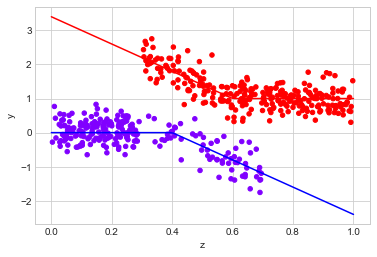

In [55]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

In [56]:
# OLS estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.010      0.054     37.164      0.000      1.904      2.116
           ATC      2.007      0.063     31.636      0.000      1.882      2.131
           ATT      2.013      0.067     29.852      0.000      1.881      2.145



/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [57]:
# Matching estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.114      0.181     11.710      0.000      1.760      2.468
           ATC      2.241      0.291      7.705      0.000      1.671      2.811
           ATT      2.007      0.220      9.143      0.000      1.577      2.438



The OLS estimator fails to capture the true effect, and while the matching estimator improves things a bit, there just isn't enough information in the data to extrapolate fully into areas where there isn't overlap.

This example might seem contrived - that's because it is, but once we start looking covariates with higher dimensionality this issue can become much more common.

`causalinference` provides a useful tool to quickly assess the overlap of the variables using the `summary_stats` property:

In [58]:
print(cm.summary_stats)


Summary Statistics

                       Controls (N_c=229)         Treated (N_t=271)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -0.139        0.483        1.198        0.484        1.337

                       Controls (N_c=229)         Treated (N_t=271)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.266        0.197        0.675        0.196        2.082



Where the Normalized difference is defined as

$\frac{\bar{X}_{T} - \bar{X}_{T}}{ (\sigma^{2}_{T} + \sigma^{2}_{C})/2 } $

While it isn't a strict statistical test, it provides some indication how much overlap there is between each covariate. Values greater than one suggest there isn't much overlap.

# Propensity Score

The Propensity score is a estimate of how likely it is for a subject to have ended up with the treatment, given the covariates:

$\hat{p}(Z) = P(X|Z)$

We can estimate this however we like, but once we have it there are a number of things we can do with it.


## Inverse Propensity Score Weighting

Remember that the problem of measuring causal inference is that we want to know the quantity $E[Y_{i}]$, but we only have access to samples from $E[Y_{i}|X=i]$.

The probability of a potential outcome can be expanded to give

$P(Y_{i}) = P(Y_{i}| X = i)P(X = i)$

This suggests that we can estimate the true 

$E[Y_{i}] = E[\frac{Y_{i}}{P(X=i|Z)}P(X=i|Z)] = E[\frac{Y_{i}}{P(X=i|Z)}|X=i, Z]$

So if we weight each point by it's inverse propensity, we can recover the potential outcomes. The result is the [inverse propensity score weight estimator](https://en.wikipedia.org/wiki/Inverse_probability_weighting):

$\Delta_{IPS} = \frac{1}{N}\left(\sum_{i \in 1} \frac{y_{i}}{\hat{p}(z_{i})} - \sum_{i \in 0} \frac{y_{i}}{1 - \hat{p}(z_{i})}\right)$

Let's see how it does one of our previous datasets:

Observed ATE: 0.108 (0.101)
Real ATE:  -0.504 (0.025)


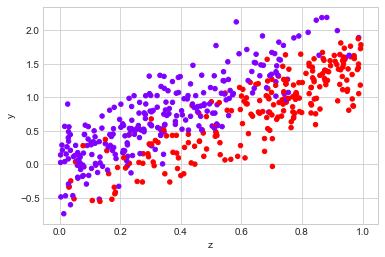

In [59]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

We can estimate the propensity using the `CausalInference` package's methods `est_propensity_s` or `est_propensity`, which uses logistic regression on the covariate to estimate propensity:

In [60]:
cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()

propensity = cm.propensity["fitted"]

df = observed_data_1

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.448142318058761

This does well in our situation - by is very dependent on how good our estimate of the propensity score is - for the data generator we're using for this example the relationship can be described well by plain logistic regression. If we tried to estimate the propensity using, say, `sklean's` logistic regression function, which by default uses regularization, we would have got the wrong answer:

In [61]:

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
X = df.z.values.reshape(-1,1)
y = df.x.values
lg.fit(X,y)

propensity = lg.predict_proba(X)[:,1]

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.34794980508652873

It does better than our naive estimator, but is not correct.

# Doubly Robust Weighted Estimator

We can combine the inverse propensity score weighting estimators and the linear estimator of effect size together to try and reduce the flaws in either model. This is done by preforming weighted linear regression on the data, with each point weighted by the inverse propensity score. The result is the [doubly robust weighted estimator](https://academic.oup.com/aje/article/173/7/761/103691). 

The idea is that points because there is an bias in which samples are treated in the observational data, the samples which were treated, but were unlikely to have been, are more import and should be given more weight.

We can apply it using the following:

Observed ATE: 0.129 (0.100)
Real ATE:  -0.505 (0.025)


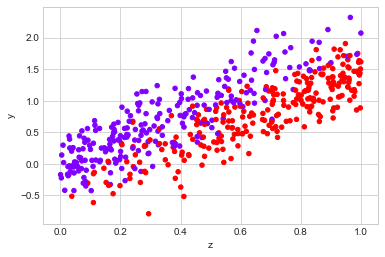

In [62]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_1)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_1)))

In [63]:
## I personally like the doubly robust weighted estimator

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.529      0.031    -16.865      0.000     -0.590     -0.467



/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [64]:
cm.estimates

{'weighting': {'ate': -0.5286028642808227, 'ate_se': 0.03134371324109197}}

# Unconfoundedness and the Propensity Score 

In the previous sections, we assumed that the outcomes and the treatment were independent given our covariates:

$Y_{1}, Y_{0} \ci X \, | \,Z$

We can also assume something slightly stronger: that the outcomes are independent of the treatment, conditioned on the probability of the propensity:

$Y_{1}, Y_{0} \ci X \, | \,\hat{p}(Z)$

With this assumption, we potentially reduce the dimensionality of the confounding variables. This allows us to perform several techniques which may not work in higher dimensional settings. 

# Trimming

We previously saw that imbalances in covariates can create issues. A simple solution is to only make predictions for the counterfactual in regions where there is a good overlap, or "trim" points where there is not good overlap. For high dimensional data "good overlap" can be difficult to define - using just the propensity score to define overlap is one way to solve this. 

Let's look at a dataset with low overlap:

Observed ATE: 1.360 (0.077)
Real ATE:  2.461 (0.034)


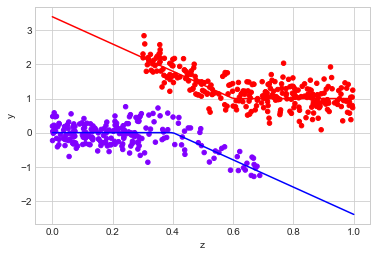

In [65]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

`CausalInference` offers a method to trim the data based on the propensity score

In [66]:
# OLS estimator
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_propensity_s()
cm.trim_s()
cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.952      0.139     14.065      0.000      1.680      2.224
           ATC      2.083      0.261      7.971      0.000      1.571      2.595
           ATT      1.842      0.100     18.421      0.000      1.646      2.037



We can look at the remaining data in the following way

Observed ATE: 1.665 (0.119)
Real ATE:  1.985 (0.030)


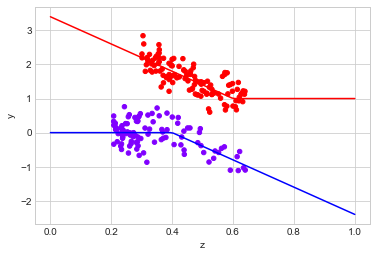

In [67]:
# mask out data ignored by the 
propensity = cm.propensity["fitted"]
cutoff = cm.cutoff
mask = (propensity > cutoff) &  (propensity < 1 - cutoff)

# plot the data
observed_data_3[mask].plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")

# filter out data in regions we have trimmed when we calculate the true uplift
filter_ = lambda df: (df.z > 0.2) & (df.z < 0.7)

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(observed_data_3[mask])))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(
    **run_ab_test(dg.generate_dataset_3, filter_= filter_)))

It does quite well in there cases.

When we apply trimming, we are explicitly saying that it is only possible to make causal inferences for samples in some part of the covariate space. For samples outside these regions, we cannot say anything about the ATE.

# Stratification

Another use of the propensity score is the stratification, or blocking, estimator. It consist of grouping the data points into groups of similar propensity, and to estimate the ATE within these groups. Again, `CausalInference` provides a nice interface to achieve this. 

We use the `stratify` (for user defined stata boundaries) or `stratify_s` (to automatically choose the boundaries) methods to determine the strata:

In [68]:
observed_data_1 = dg.generate_dataset_1()

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_propensity_s()
cm.stratify_s()

print(cm.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.079     0.188       111        15     0.125     0.137    -0.487
         2     0.190     0.315        49        14     0.249     0.263    -0.611
         3     0.321     0.447        30        32     0.377     0.395    -0.590
         4     0.452     0.620        33        30     0.535     0.549    -0.532
         5     0.621     0.692        13        18     0.652     0.653    -0.653
         6     0.694     0.740         4        27     0.714     0.723    -0.716
         7     0.743     0.827        18        44     0.783     0.784    -0.684
         8     0.829     0.903         7        55     0.871     0.869    -0.632



and the `est_via_blocking` method to combine the estimates of these strata into one overall ATE:

In [69]:
cm.est_via_blocking()
print(cm.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.608      0.035    -17.332      0.000     -0.677     -0.539
           ATC     -0.585      0.039    -14.899      0.000     -0.662     -0.508
           ATT     -0.634      0.044    -14.272      0.000     -0.721     -0.547



/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


Which again works well.

Stratify the data into groups by propensity score is useful when we don't have any prior knowledge of what constitutes "similar" units, however it is not the only way. If you have prior knowledge the different groups of your samples are likely to be affected by the intervention in similar ways, it makes sense to split you samples into these groups before estimating the ATE, then pooling the results to get a global ATE. 

# Which Technique to Use?

I've now covered most the of the common techniques for causal inference from observational data. The remaining question is how to decide which method to use? This is not an easy question. While there are some automated techniques, like [this paper](https://arxiv.org/pdf/1711.00083.pdf), I haven't had a change to try them out. 

Ultimately, to choose your technique you need to make some assumptions about how you contruct you counter factual. If you trust you data to have good over in covariate space, matching is a good approach because there is always some nearby point with the opposite treatment. When this isn't the case, you need to either use a model you trust to extrapolate well into unexplored areas or make the assumption that something like the propensity score captures enough information to assume ignorability.

To highlight that all these methods can fail, I have one more example. Unlike the previous examples, there is more than one covariate. Like all the previous datagenerators, this one also obeys the assumption 

$Y_{1}, Y_{0} \ci X \, | \,Z$

By design. 

Let's blindly try the methods we've discussed so far and see what happens

In [70]:
data_gen = dg.generate_exercise_dataset_2
ds = data_gen()

print("Observed ATE: {estimated_effect:.3f} ({standard_error:.3f})".format(**estimate_uplift(ds)))
print("Real ATE:  {estimated_effect:.3f} ({standard_error:.3f})".format(**run_ab_test(data_gen)))

zs = [c for c in ds.columns if c.startswith("z")]

cm = CausalModel(
    Y=ds.y.values, 
    D=ds.x.values, 
    X=ds[zs].values)

cm.est_via_ols()
cm.est_via_matching()
cm.est_propensity_s()
cm.est_via_weighting()

cm.stratify_s()
cm.est_via_blocking()

print(cm.estimates)

Observed ATE: 0.726 (0.714)
Real ATE:  4.716 (0.184)


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.710      0.333      2.130      0.033      0.057      1.364
           ATC      1.456      0.372      3.910      0.000      0.726      2.186
           ATT      0.385      0.338      1.139      0.255     -0.277      1.046

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.026      0.513      3.949      0.000      1.020      3.032
           ATC      2.115      0.668      3.168      0.002      0.807      3.424
           ATT      1.987      0.559      3.554      0.000      0.891      3.083

Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. in

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


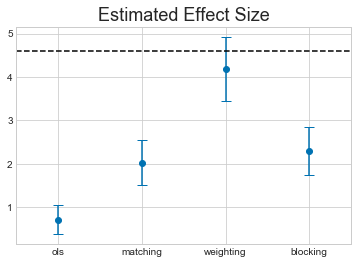

In [71]:
y = []
yerr = []
x_label = []

for method, result in dict(cm.estimates).items():
    y.append(result["ate"])
    yerr.append(result["ate_se"])
    x_label.append(method)
    
x = np.arange(len(y))

plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
plt.xticks(x, x_label)
plt.title("Estimated Effect Size", fontsize=18)
plt.hlines(4.6, -0.5, 3.5, linestyles="dashed")
plt.xlim(-0.5,3.5);

The horizontal dashed line shows the true ATE for this dataset.

Not only do we have a range of different results from each technique, they all miss the true value. 

This should be a warning about the limitations of this kind of technique. It might be an intesteresting exercise for the reader to try and work about what properties of the dataset cause these methods to miss the true value.

# The Structure of Causal Inference

Hopefully by this point, you will have realised the importance of the ignorability assumption

$Y_{1}, Y_{0} \ci X \, | \,Z$

What I haven't talked about is how we choose $Z$ so that this is true. Ultimately this needs to come from domain knowledge about the system being studied. There are a set of powerful tools called [Causal Graphical Models](https://en.wikipedia.org/wiki/Causal_graph) which allow you to encode knowledge about the system being studied is a graphical model of the system and to reason about conditional independence assumptions like the one above.

I hope to discuss this in a later post.